# The Midnight Mystery - Report (Mat: 257832)



och yer hae wi' ye thocht telt aboot tae throo charade yer ye yer


/tmp/ipykernel_6311/3221167645.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


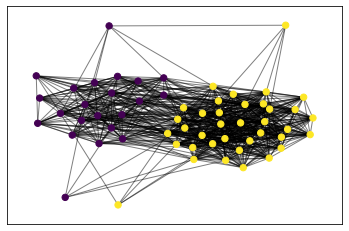

                    guest       location  uses_dialect  note_similarity  \
31     Viscount Pemberton         cellar          True         0.396365   
25        Doctor Ashcroft   conservatory          True         0.404062   
13           Baron Sienna           hall          True         0.390973   
55        Inspector Ivory           hall          True         0.337435   
20        Brigadier Black       ballroom          True         0.335596   
45   Counselor Montgomery           hall          True         0.325330   
41          Viscount Onyx        library          True         0.308643   
33             Lord Green         lounge         False         0.361355   
18        Ambassador Gold        kitchen         False         0.298632   
22            Mister Onyx        library         False         0.298145   
57    Duchess Summerville    dining room         False         0.290214   
39  Solicitor Ravenscroft           hall         False         0.285726   
10          Rector Violet

In [60]:
#IDEA: 1. transform note and compute similarity with the style of the statements (note that the note is not written entirely using a dialect...)
#      2. compute graph of people who saw each other and display it to find inconsistencies
#      3. (OUTDATED, FINAL EXAM DOES NOT REQUIRE IT) find, through the statements, the people that were the closets to the crime scene (which means, as we do not have a map of the house, who was in the crime location)
#      4. compute the probability for each suspect using the softmax

import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sentence_transformers import SentenceTransformer, util
import community as community_louvain
from collections import defaultdict
from scipy.special import softmax
from openai import OpenAI

def statement_similarity(statement):
    """
    The following function creates the embedding of the provided statement and compares it with the one of the note, calculating
    the cosine similarity between the two.
    """
    emb = model.encode(statement, convert_to_tensor=True)
    return util.cos_sim(note_embedding, emb).item()

def has_dialect(text):
    """
    The following function simply determines whether someone is using a dialect in their statement. In order to do this, we use the
    words contained in the note found on the corpse. Note that it does not recognize the intensity of it and that is a pretty naive
    approach to the task.
    """
    text = text.lower()
    for word in dialect_keywords:
        if text.find(word) != -1: 
            return True
    return False

def find_location(statement):
    """
    The function tries to find the location of the witness by searching the statement for the available locations and
    If we find the location, we exit the loop (the person can be present only in one place at a time).
    We then return the obtained location (if not match, a placeholder
    string containing "Void" is returned).
    """
    location = "Void" #default case, if no match in the following code
    for i in locations:
        if statement.find(i) != -1:
            location = i
            break
    return location

def find_sightings(statement):
    """
    The function tries to find the people the witness saw by searching the statement for the people present at the scene.
    We simply search all the guests the witness saw and we store those in a list. We then return the obtained list of people
    the guest says to have seen.
    """
    sightings = []
    for j in guests:
        if statement.find(j) != -1:
            sightings.append(j)
    return sightings

def assign_worse_score(guest):
    """
    This function assigns a value to each guest based on the partition they belong to: if they belong to a populous partition, it's more
    likely they are not the ones that committed the crime, so we diminsh their suspect score. If, instead, they belong to the least populous
    partition, they are more likely to be suspicious, hence we assign them an ulterior penalty
    """
    if partition[guest] == smallest_community[0]:
        return 0.15
    elif partition[guest] == biggest_community[0]:
        return -0.15
    else:
        return 0
        

#used in previous exercise, remains here if needed
#def location_malus(location):
#    """
#    A simple function that gives a malus to those guests that were in the same room as the victim while doing nothing for the other guests.
#    """
#    if location == murder_location:
#        return 1
#    else:
#        return 0


#load the data from the given json
with open('murder_mystery.json') as f:
    data = json.load(f)
metadata = data['metadata']
interrogations = data['interrogations']

#we extract a lot of information contained in there
#victim = metadata['victim'] #not really useful here, in a real setting this would be a vital information
#murder_time = metadata['murder_time'] #not really useful here, in a real setting this would be a vital information
#murder_location = data['solution']['murder_location'] #used in a previous version, remains here if needed
note = metadata['victim_note']
guests = [interrogations[i]['guest'] for i in range(0,len(interrogations))]
locations = metadata['locations']

#we create some DataFrames to easily handle the data we are going to generate and to access in an easier manner the interrogations' fields
df = pd.DataFrame(interrogations) #makes it easier to access its fields
res = pd.DataFrame() #we store the various metrics we are going to use here
res['guest'] = guests
statements = [interrogations[i]['statement'] for i in range(0, len(interrogations))]

#we use some keywords to identify who is speaking in a dialect (obtained from ChatGPT)
client = OpenAI(
    api_key = "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",
    base_url= "https://openrouter.ai/api/v1"
)

response = client.chat.completions.create(
    model="openai/gpt-4",  # or "openai/gpt-3.5-turbo"
    messages=[
        {"role": "user", "content": "I have the following message: " + note + ". It contains a mixture of dialect and correct English words. "
        + "Your job is that of extracting keywords that can be used to understand if someone is using the same dialect in another statement. ONLY PROVIDE THE VALUES FORMATTED IN A STRING SEPARATED BY WHITE SPACES AND NOTHING MORE, DO NOT INCLUDE ANYTHING ELSE IN YOUR RESPONSE, LOWERCASE ALL YOUR OUTPUTS"}
    ]
)
print(response.choices[0].message.content)
dialect_keywords = response.choices[0].message.content.split()
dialect_keywords.pop(0) #"och", gives a lot of false positives and is always present

#we create the embeddings of the note found on the corpse and then we compute the cosine similarity with every single statement (this in order
#to find people that have a similar writing style or choice of words to the note)
model = SentenceTransformer('all-MiniLM-L6-v2')
note_embedding = model.encode(note, convert_to_tensor=True)
res['note_similarity'] = df['statement'].apply(statement_similarity)

#we then compute various useful informations for every single guest, such as the location of the person at the time of the crime, the people they saw whether they use
#a dialect or not and whether they were where the crime happened - in these last two cases, a penalty is later on applied to the suspect score
#of the specific guest
res['location'] = df['statement'].apply(find_location)
res['sightings'] = df['statement'].apply(find_sightings)
res['uses_dialect'] = df['statement'].apply(has_dialect)
#res['location_penalty'] = res['location'].apply(location_malus) #applies to old version of exercise
"""
#APPLIED IN OLD VERSION OF EXERCISE - CAN'T USE IT HERE SINCE WE DON'T HAVE THE CRIME LOCATION
#we compute the people that were present on the scene of the crime and we give a penalty to those that they saw - it may be a divertion, but they
#may also be more suspicious than others, especially if saw by multiple people on the scene
res['seen_near_crime_scene'] = 0
in_scene = []
for i in range(0, len(guests)):
    if res['location_penalty'][i] == 1:
        in_scene.append(guests[i])
print(in_scene)
for i in range(0, len(guests)):
    if guests[i] in in_scene:
        people_saw = res['sightings'][i]
        for j in people_saw:
            res['seen_near_crime_scene'][guests.index(j)] = res['seen_near_crime_scene'][guests.index(j)] + 0.1
"""

#we create a graph and add as nodes the guests and as edges the sightings we previously got
G = nx.Graph()
G.add_nodes_from(guests)
guest_index = 0
for i in guests:
    for j in res['sightings'][guest_index]:
        G.add_edge(i, j)
    guest_index = guest_index + 1

#we partition the graph using louvain to try and find communities and eventual outliers
partition = community_louvain.best_partition(G)
#we draw the graph
pos = nx.spring_layout(G)
#we color the nodes according to their partition (code from https://python-louvain.readthedocs.io/en/latest/api.html)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

#we get the least populous partition and we give a penalty to those belonging to it, while we give a small reward to those belonging to the
#most populous one, as we assume the more people saw someone else, the less likely it is that it was the one to commit the homicide.
#Note however that outliers may escape this method and get a penalty or a reward even when they shouldn't - because of this, we just give a
#small value to this update. Also note that people in middle-sized communities are not affected by this.
community_to_nodes = defaultdict(list)
for node, community_id in partition.items():
    community_to_nodes[community_id].append(node)
smallest_community = min(community_to_nodes.items(), key=lambda x: len(x[1]))
biggest_community = max(community_to_nodes.items(), key=lambda x: len(x[1]))
res['partition_penalty'] = res['guest'].apply(assign_worse_score)

#we rank the suspects in two ways: in the first one we compute the raw score using the note similarity, their use of a dialect, their partition penalty and their location penalty
#Then, we normalize such scores using a softmax to obtain some probabilities in output
res['suspect_score'] = res['note_similarity']*1.5 + res['uses_dialect'].astype(float) + res['partition_penalty']
res['softmax_score'] = softmax(res['suspect_score'])

#we sort the suspects and then display them, together with some useful information to understand the ordering
suspects = res.sort_values(by='suspect_score', ascending=False)
print(suspects[['guest', 'location', 'uses_dialect', 'note_similarity', 'suspect_score', 'softmax_score', 'partition_penalty']])


# Report
The following report exposes the methodology used in order to resolve the exercise and the results obtained using it, together with a discussion about the results.<br>
First of all, in order to understand who the murderer is, we used various kinds of techniques to explore different hints that could give away the culprit. In detail, we used: <br>
1] **Embeddings**: We computed the embedding of the note found on the body and calculated the cosine similarity with the embedding of each of the statements in order to understand whose style resembles more the one that is used in the note. We use this as a basis for the computation of a suspect score later on.<br>
2] **LLM**: We asked ChatGPT to compute a series of keywords from the note found on the corpse in order to be able to find those people that also use a dialect in their statement. We use this just as a penalty on the final suspect score. We also tried to ask it to grade the certainty that people had about meeting other people, due to some having been quickyl seen, which means the person may actually be mistaken about their identity, but this attempt did not work that well, which is why we scraped it in the end.<br>
3] **Community Networks**: We used Louvain's algorithm to find communities in the guests' group by creating a graph using the guests as nodes and who they saw before the crime happened as the edges. This is used to understand which guests are less connected to the others, which could lead to them being labelled as suspicious, while, at the same time, find those that have been seen by a lot of people and can thus be considered less likely to have committed the homicide. This approach could be expaneded upon to also consider the room in which each person claimed to be, especially if used with a map that showed the nearness of each room to the crime scene, but for this problem this approach is not usable due to the lack of information. Also, we could have used some weighs on the various arcs based on the way the person interacted with the other one (for example, if they played cards, it's highly probable the identification was right, but if someone saw another person briefly, it may have confused it with another one, thus the edge would need to have a lower weight). However, we have not been able to correctly implement it, so we only expose the idea here, as it could be used to weight the suspect score in a more intelligent way and obtain better results.<br>
4] **Logical Deductions**: We did some simple logical deductions based on the statements given by the various guests in order to apply some penalty to those that have more suspicious traits. We do this for the following trait: <br>
    -dialect (if a person has the same dialect as the note, they may have been the one to do this - assuming this is not a red herring. Also note that the note is not completely in dialect, but also uses correct English, so this may give away some information) <br>
    Earlier version of the notebook also included a penalty for the location of the victim, but in the final exam this aspect has been removed, so this part has been scrapped.<br>
5] **Score Computing**: We computed a suspect score using the following values: the cosine similarity between the statement and the note (multiplied by 1.5 to give it more importance, as we do believe this similarity to be the key to solve the mystery), the penalty applied to a person speaking in dialect and a penalty applied to those that belong to the less populated partition. After this, we normalize the score using the SoftMax function and we obtain a series of probabilities for each individual.<br>

# RESULTS
Executing the above described code, we get that the most likely suspect is **Doctor Ashcroft** (though the algorithm says that the most probable is Viscount Pemberton), supported by the fact that his statement is really similar in style to the note found on the body, by the fact that he speaks in a dialect and, if we were to investigate the various statements provided by the guests, all the guests that have seen him are not sure or just saw him quickly, which makes his whereabouts fuzzy at best and suspicious at worst. Meanwhile, the other culprits suggested by the algorithm, so **Viscount Pemberton, Brigadier Black, Viscount Onyx, Baron Sienna, Inspector Ivory and Counselor Montgomery**, while they all speak a dialect and have a relatively high similarity in style with the note found on the corpse, have been either seen by a lot of people (it's the case of people like Sienna, Ivory and Montgomery), which makes it less likely that they had the opportunity to execute the homicide, while for what concerns Onyx, Black and Pemberton, all of them were surely seen by other people (for example, Onyx talked with Ambassador Gold, Black was with duchess Ravenswood and Pemberton was talking with Professor Blackstone), making their likelihood of committing the crime lower. Also, if we were to refine the community finding, we would maybe be able to tell that they belong to not isolated communities, which could also lower the chance of them being the culprit, but, as the algorithm only flound 2 clusters, this is not really possible. <br>
Having said all of this, we are pretty confident that **Doctor Ashcroft** is the most likely suspect.